In [1]:
#######################################
# COMS30014 - Artificial Intelligence #
# Multiagent Systems Lab - I          #
# Covid-19 Simulation                 #
#######################################

# Before starting, make sure you have installed Mesa 
# You could install via command line --- pip install mesa
# For generating plots, you will need matplotlib which too you can install via command line --- pip install matplotlib

In [2]:
NUM_OF_AGENTS = 1000

# PLACES
PARK = 0
HOME = 1
GROCERY = 2
QC = 3 # Quarantine center
VC = 4 # Vaccination Center

# INFECTION STATES
NOT_INFECTED = 0
INFECTED_A = 1
INFECTED_S = 2
CRITICAL = 3
#CURED = 4
DECEASED = 4

# Capacity of quarantine center
QC_LIMIT = 100 # Capacity of quarantine center
VC_CAP = 10

In [3]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import random

class HumanAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.homeId = unique_id//4
        self.health = NOT_INFECTED
        self.vaccinated = 0
        self.compliance = random.uniform(0,1)
        self.mask = 0

    def step(self):
        self.updateHealth()
        self.move()

    # Function for mobility pattern modeling
    
    def move(self):
        x, y = self.pos
        if x==QC:
            return
        if self.model.quarantine and self.model.QC_Occupancy < QC_LIMIT and self.health == CRITICAL:
            self.model.grid.move_agent(self, (QC,0))
            self.model.QC_Occupancy += 1
            return
        if self.model.quarantine and self.model.QC_Occupancy < QC_LIMIT and self.health == INFECTED_S and self.random.uniform(0, 1) <= self.compliance:
            self.model.grid.move_agent(self, (QC,0))
            self.model.QC_Occupancy += 1
            return
        if x == HOME:
            p = self.random.uniform(0, 1)
            # Visit park with 10% probability
            if p <= 0.1:
                newX = PARK
                newY = self.random.choice((0,1)) # Visit one of the two parks
                if self.random.uniform(0,1) <= self.compliance:
                    self.mask = 1
            # Visit grocery store with 20% probability
            elif p <= 0.3:
                newX = GROCERY
                newY = self.random.choice((0,1,2,3,4)) # Visit one of the five grocery stores
                if self.random.uniform(0,1) <= self.compliance:
                    self.mask = 1
            else:
                if self.vaccinated == 0 and self.random.uniform(0,1) <= self.compliance and self.model.VC_Occupancy < VC_CAP:
                    self.model.VC_Occupancy += 1
                    self.vaccinated = 1
                    newX = VC
                    newY = 0
                else:
                    newX = x
                    newY = y
        if x == GROCERY or x == PARK: # If grocery or park or VC, return home
            newX = HOME
            newY = self.homeId
            self.mask = 0
        if x == VC:
            newX = HOME
            newY = self.homeId
            self.mask = 0
            self.model.VC_Occupancy -= 1
        self.model.grid.move_agent(self, (newX,newY))

    # Function for modeling the spread of the virus

    def updateHealth(self):
        p = self.random.uniform(0, 1)

        alpha = 1.0
        if self.vaccinated == 1:
            alpha = 0.5

        beta = 1.0
        x,y = self.pos
        if x == HOME:
            beta = 2.0

        if self.health == INFECTED_A:
            if p <= 0.36*alpha:
                self.health = INFECTED_S
            elif p <= 0.36*alpha+0.2*beta:
                self.health = NOT_INFECTED
        elif self.health == INFECTED_S:
            if p <= 0.01*alpha:
                self.health = CRITICAL
            elif p <= 0.01*alpha+0.1*beta:
                self.health = NOT_INFECTED
                if x == QC:
                    self.model.QC_Occupancy -= 1                
        elif self.health == CRITICAL:
            if p <= 0.2*alpha:
                self.health = DECEASED
                self.model.deceasedCount += 1
                if x == QC:
                    self.model.QC_Occupancy -= 1
            elif p <= 0.2*alpha+0.05*beta:
                self.health = NOT_INFECTED
                if x == QC:
                    self.model.QC_Occupancy -= 1
        return
    
    def infect(self):
        p = self.random.uniform(0, 1)
        p0b = self.model.p0b
        if self.vaccinated==1: p0b = 0.5*p0b
        if self.mask==1: p0b = 0.5*p0b
        if self.health == NOT_INFECTED and p > p0b:
            self.health += 1


def compute_infected(model):
    infectedAgents = [agent for agent in model.schedule.agents if agent.health in (INFECTED_A, INFECTED_S, CRITICAL) ]
    return len(infectedAgents)

class CovidModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, startingState, quarantine = False, socialDistancing = False):
        self.num_agents = N
        # self.random.seed(42)
        self.QC_Occupancy = 0
        self.deceasedCount = 0
        self.quarantine = quarantine
        self.grid = MultiGrid(4 if quarantine else 3, 250, False)
        self.schedule = RandomActivation(self)
        self.running = True
        self.VC_Occupancy = 0
        
        # With socialdistancing the probability of infection is 10% (p0b = 0.9) otherwise it is 50%
        self.p0b = 0.5
        
        ###########
        # HINT: 
        # You need to update the the next if block to correctly set infection probability when social distancing is TRUE
        # You need to change quarantine center capacity too
        ###########
        if socialDistancing:
            self.p0b = 0.9
        else:
            self.p0b = 0.5
        ###########
        
        # Create agents
        for i in range(self.num_agents):
            a = HumanAgent(i, self)
            self.schedule.add(a)
            self.grid.place_agent(a, (HOME, a.homeId))
        for a in self.random.sample(self.schedule.agents,int(startingState*N)):
            a.health = INFECTED_A
        self.datacollector = DataCollector(
            model_reporters={"Infected": compute_infected,
                             "QC_Occupancy": "QC_Occupancy"}
            )
    def step(self):
        self.datacollector.collect(self)
        '''Advance the model by one step.'''
        self.schedule.step()
        self.identifyAgentsAndUpdateSpread()
    def identifyAgentsAndUpdateSpread(self):
        # Park
        for y in range(2):
            agents = self.grid.get_cell_list_contents([(PARK,y)])
            self.updateSpread(agents)
        # Grocery
        for y in range(5):
            agents = self.grid.get_cell_list_contents([(GROCERY,y)])
            self.updateSpread(agents)
        # Home
        for y in range(250):
            agents = self.grid.get_cell_list_contents([(HOME,y)])
            self.updateSpread(agents)
    def updateSpread(self, agents):
        if any(a.health in (INFECTED_A, INFECTED_S, CRITICAL) for a in agents):
            [a.infect() for a in agents]

In [4]:

def runSimulation(startingState,quarantine=False,socialDistancing=False):
    modelInst = CovidModel(NUM_OF_AGENTS, startingState, quarantine, socialDistancing)
    i=0
    while any(a.health in (INFECTED_A, INFECTED_S, CRITICAL) for a in modelInst.schedule.agents):
        i += 1
        modelInst.step()
    modelDF = modelInst.datacollector.get_model_vars_dataframe()
    
    return i, modelInst.deceasedCount, modelDF.QC_Occupancy,modelDF.Infected

# Scenario 1a. No Quarantine Centers and No Social Distancing; 10% Infection at Start
StartingState = 10%

Quarantine=False

Social Distancing=False

In [5]:
StartingState = 0.1
quarantine=False
socialDistancing=False

averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageCasualties = 0
for i in range(10):
    days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState,quarantine,socialDistancing)
    averageDays+=days
    dayWithMaxInfectionRate+=Infected.idxmax()
    maxInfection += Infected.max()
    averageCasualties += Casualties
    if i == 9:
        # QC_Occupancy.plot(legend=True)
        Infected.plot(legend=True)
print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))


Exception: Point out of bounds, and space non-toroidal.

# Scenario 1b. No Quarantine Centers and No Social Distancing; 25% Infection at Start
StartingState = 25%

Quarantine=False

Social Distancing=False

Average number of days before stabilization: 40.9
Average of the Day with peak Infection (795.6): 4.4
Average Number of Casualties: 78.4


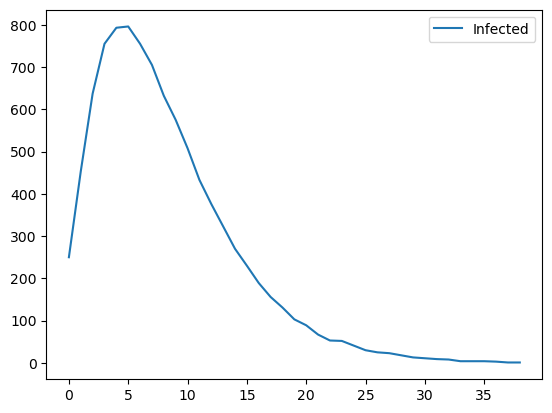

In [ ]:
StartingState = 0.25
quarantine=False
socialDistancing=False

averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageCasualties = 0
for i in range(10):
    days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState,quarantine,socialDistancing)
    averageDays+=days
    dayWithMaxInfectionRate+=Infected.idxmax()
    maxInfection += Infected.max()
    averageCasualties += Casualties
    if i == 9:
        # QC_Occupancy.plot(legend=True)
        Infected.plot(legend=True)
print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))


# Scenario 1c. No Quarantine Centers and No Social Distancing; 50% Infection at Start
StartingState = 50%

Quarantine=False

Social Distancing=False

Average number of days before stabilization: 40.1
Average of the Day with peak Infection (842.5): 3.0
Average Number of Casualties: 83.0


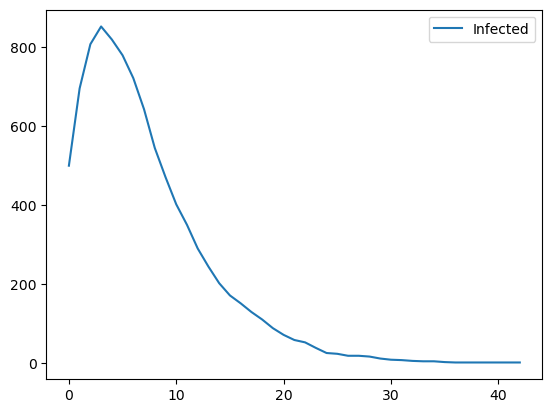

In [ ]:
# Add code for baseline 3 here
StartingState = 0.5
quarantine=False
socialDistancing=False

averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageCasualties = 0
for i in range(10):
    days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState,quarantine,socialDistancing)
    averageDays+=days
    dayWithMaxInfectionRate+=Infected.idxmax()
    maxInfection += Infected.max()
    averageCasualties += Casualties
    if i == 9:
        # QC_Occupancy.plot(legend=True)
        Infected.plot(legend=True)
print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))

# Adding Quarantine Centers
Enable quarantine centers for each baseline and see how the plots change
In the line plot, include a plot for capacity of qurantine center too

In [ ]:
# Add code to generate plots with quarantine centers here

# Scenario 2a. Quarantine Centers; 10% Infection at start)
StartingState = 10%

Quarantine=True

Social Distancing=False

Average number of days before stabilization: 45.1
Average of the Day with peak Infection (770.9): 5.6
Average Number of Casualties: 83.6
Average of Max Quarantine centre capacity utilized: 100.0
Average of Max Quarantine centre capacity utilized at: 4.7


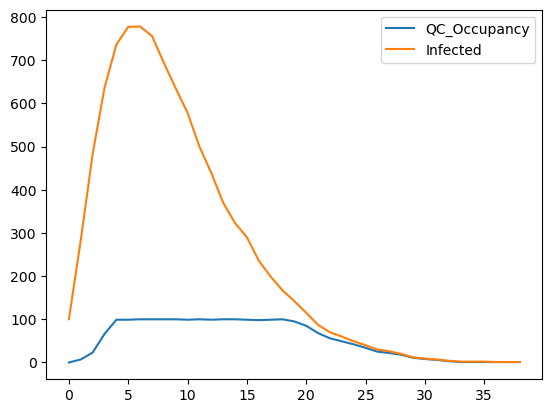

In [ ]:
StartingState = 0.1
quarantine=True
socialDistancing=False

averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageCasualties = 0
averageMaxCapacityDay = 0
averageMaxCapacity = 0
for i in range(10):
    days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState,quarantine,socialDistancing)
    averageDays+=days
    dayWithMaxInfectionRate+=Infected.idxmax()
    maxInfection += Infected.max()
    averageMaxCapacity += QC_Occupancy.max()
    averageMaxCapacityDay += QC_Occupancy.idxmax()
    averageCasualties += Casualties
    if i == 9:
        QC_Occupancy.plot(legend=True)
        Infected.plot(legend=True)
print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))
print('Average of Max Quarantine centre capacity utilized: ' + str(averageMaxCapacity/10))
print('Average of Max Quarantine centre capacity utilized at: ' + str(averageMaxCapacityDay/10))

# Scenario 2b. Quarantine Centers; 25% Infection at Start
StartingState = 25%

Quarantine=True

Social Distancing=False

In [ ]:
StartingState = 0.25
quarantine=True
socialDistancing=False

averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageCasualties = 0
averageMaxCapacityDay = 0
averageMaxCapacity = 0
for i in range(10):
    days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState,quarantine,socialDistancing)
    averageDays+=days
    dayWithMaxInfectionRate+=Infected.idxmax()
    maxInfection += Infected.max()
    averageMaxCapacity += QC_Occupancy.max()
    averageMaxCapacityDay += QC_Occupancy.idxmax()
    averageCasualties += Casualties
    if i == 9:
        QC_Occupancy.plot(legend=True)
        Infected.plot(legend=True)
print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))
print('Average of Max Quarantine centre capacity utilized: ' + str(averageMaxCapacity/10))
print('Average of Max Quarantine centre capacity utilized at: ' + str(averageMaxCapacityDay/10))

Exception: Point out of bounds, and space non-toroidal.

# Scenario 2c. Quarantine Centers; 50% Infection at Start
StartingState = 50%

Quarantine=True

Social Distancing=False

Average number of days before stabilization: 42.7
Average of the Day with peak Infection (837.6): 3.0
Average Number of Casualties: 81.9
Average of Max Quarantine centre capacity utilized: 100.0
Average of Max Quarantine centre capacity utilized at: 3.1


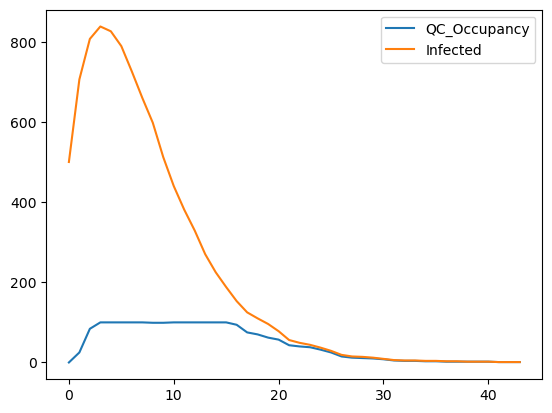

In [ ]:
StartingState = 0.50
quarantine=True
socialDistancing=False

averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageCasualties = 0
averageMaxCapacityDay = 0
averageMaxCapacity = 0
for i in range(10):
    days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState,quarantine,socialDistancing)
    averageDays+=days
    dayWithMaxInfectionRate+=Infected.idxmax()
    maxInfection += Infected.max()
    averageMaxCapacity += QC_Occupancy.max()
    averageMaxCapacityDay += QC_Occupancy.idxmax()
    averageCasualties += Casualties
    if i == 9:
        QC_Occupancy.plot(legend=True)
        Infected.plot(legend=True)
print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))
print('Average of Max Quarantine centre capacity utilized: ' + str(averageMaxCapacity/10))
print('Average of Max Quarantine centre capacity utilized at: ' + str(averageMaxCapacityDay/10))

# Enabling Social Distancing Norms
Enable social distancing norms in addition to quaratine centers for each baseline and see how the plots change
In the line plot, include a plot for capacity of qurantine center too

In [ ]:
# Add code to generate plots with social distancing and quarantine centers here

# Scenario 3a. Enforcing Social Distancing Norms; 10% Infection at Start
StartingState = 10%

Quarantine=True

Social Distancing=True

Average number of days before stabilization: 98.6
Average of the Day with peak Infection (264.2): 9.4
Average Number of Casualties: 71.8
Average of Max Quarantine centre capacity utilized: 97.0
Average of Max Quarantine centre capacity utilized at: 13.4


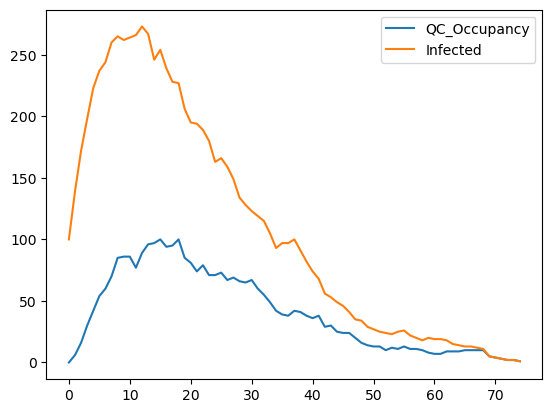

In [ ]:
StartingState = 0.10
quarantine=True
socialDistancing=True

averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageCasualties = 0
averageMaxCapacity = 0
averageMaxCapacityDay = 0
for i in range(10):
    days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState,quarantine,socialDistancing)
    averageDays+=days
    dayWithMaxInfectionRate+=Infected.idxmax()
    maxInfection += Infected.max()
    averageMaxCapacity += QC_Occupancy.max()
    averageMaxCapacityDay += QC_Occupancy.idxmax()
    averageCasualties += Casualties
    if i == 9:
        QC_Occupancy.plot(legend=True)
        Infected.plot(legend=True)
print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))
print('Average of Max Quarantine centre capacity utilized: ' + str(averageMaxCapacity/10))
print('Average of Max Quarantine centre capacity utilized at: ' + str(averageMaxCapacityDay/10))


# Scenario 3b. Enforcing Social Distancing Norms; 25% Infection at Start
StartingState = 25%

Quarantine=True

Social Distancing=True

Average number of days before stabilization: 78.5
Average of the Day with peak Infection (360.0): 4.8
Average Number of Casualties: 72.7
Average of Max Quarantine centre capacity utilized: 100.0
Average of Max Quarantine centre capacity utilized at: 7.7


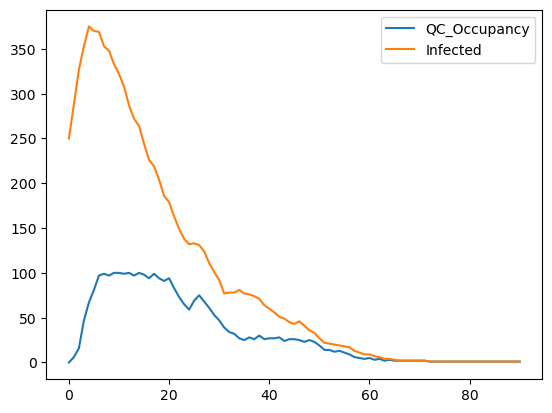

In [ ]:
StartingState = 0.25
quarantine=True
socialDistancing=True

averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageMaxCapacity = 0
averageCasualties = 0
averageMaxCapacityDay = 0
for i in range(10):
    days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState,quarantine,socialDistancing)
    averageDays+=days
    dayWithMaxInfectionRate+=Infected.idxmax()
    maxInfection += Infected.max()
    averageMaxCapacity += QC_Occupancy.max()
    averageMaxCapacityDay += QC_Occupancy.idxmax()
    averageCasualties += Casualties
    if i == 9:
        QC_Occupancy.plot(legend=True)
        Infected.plot(legend=True)
print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))
print('Average of Max Quarantine centre capacity utilized: ' + str(averageMaxCapacity/10))
print('Average of Max Quarantine centre capacity utilized at: ' + str(averageMaxCapacityDay/10))


# Scenario 3c. Enforcing Social Distancing Norms; 50% Infection at Start
StartingState = 50%

Quarantine=True

Social Distancing=True

Average number of days before stabilization: 70.4
Average of the Day with peak Infection (559.5): 2.3
Average Number of Casualties: 71.9
Average of Max Quarantine centre capacity utilized: 100.0
Average of Max Quarantine centre capacity utilized at: 3.5


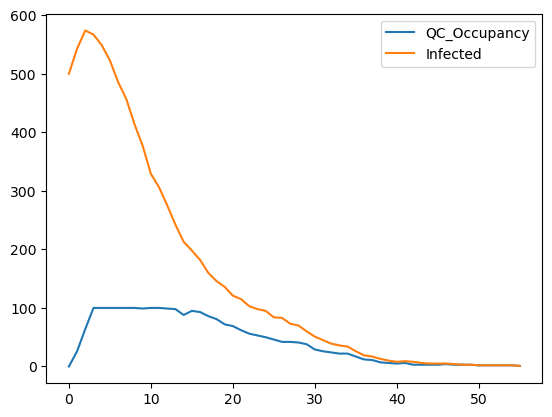

In [ ]:
StartingState = 0.5
quarantine=True
socialDistancing=True

averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageMaxCapacity = 0
averageCasualties = 0
averageMaxCapacityDay = 0
for i in range(10):
    days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState,quarantine,socialDistancing)
    averageDays+=days
    dayWithMaxInfectionRate+=Infected.idxmax()
    maxInfection += Infected.max()
    averageMaxCapacity += QC_Occupancy.max()
    averageMaxCapacityDay += QC_Occupancy.idxmax()
    averageCasualties += Casualties
    if i == 9:
        QC_Occupancy.plot(legend=True)
        Infected.plot(legend=True)
print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))
print('Average of Max Quarantine centre capacity utilized: ' + str(averageMaxCapacity/10))
print('Average of Max Quarantine centre capacity utilized at: ' + str(averageMaxCapacityDay/10))
